In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.signal
import torch as torch
import torch.nn.functional as F
import rasterio as rio
import rasterio.windows

import copy

from tqdm.notebook import tqdm

from hyperspectral.math import zca_whitening_matrix
from hyperspectral.band_selection import *

# Explore #

In [ ]:
spectrum = []
with open('data2/spectra/1/splib07a_Oil_Water_Benzene17_DWH10-3_ASDHRa_AREF.txt', 'r') as f:
    f.readline()
    for line in f.readlines():
        spectrum.append(float(line))
spectrum = np.array(spectrum)
spectrum = spectrum / np.linalg.norm(spectrum, ord=2)
spectrum_normalized = scipy.signal.resample(spectrum, 224) - spectrum.mean()

In [ ]:
plt.plot(spectrum_normalized)

In [ ]:
def infer1(in_filename, out_filename):
    with rio.open(in_filename, 'r') as in_ds:
        profile = copy.deepcopy(in_ds.profile)
        profile.update(count=1, driver='GTiff', bigtiff='yes', compress='deflate', predictor='2', tiled='yes', dtype=np.float32, sparse_ok='yes')
        with rio.open(out_filename, 'w', **profile) as out_ds:
            for col in tqdm(range(0, in_ds.width, 512), position=0):
                width = min(col+512, in_ds.width) - col
                for row in tqdm(range(0, in_ds.height, 512), position=1, leave=False):
                    height = min(row+512, in_ds.height) - row
                    window = rasterio.windows.Window(col, row, width, height)
                    data = in_ds.read(1, window=window)
                    if np.abs(data).sum() == 0:
                        continue
                    data = np.transpose(in_ds.read(window=window).astype(np.float32), (1,2,0))
                    norm = np.linalg.norm(data, ord=2, axis=2)[..., None].astype(np.float32)
                    data /= norm
                    data -= np.mean(data, axis=2)[...,None]
                    data = np.dot(data, spectrum_normalized)
                    data[np.isnan(data)] = 0
                    data = data.reshape(1, width, height).astype(np.float32)
                    out_ds.write(data, window=window)

In [ ]:
in_out = [
 ('data2/f100520t01p00r17rdn_b/f100520t01p00r17rdn_b_sc01_ort_img.tif', 'data/f100520t01p00r17rdn_b_sc01_ort_img_result.tif'),
 ('data2/f100824t01p00r25rdn_b/f100824t01p00r25rdn_b_sc01_ort_img.tif', 'data/f100824t01p00r25rdn_b_sc01_ort_img_result.tif'),
 ('data2/f100506t01p00r17rdn_b/f100506t01p00r17rdn_b_sc01_ort_img.tif', 'data/f100506t01p00r17rdn_b_sc01_ort_img_result.tif'),
 ('data2/f100517t01p00r11rdn_b/f100517t01p00r11rdn_b_sc01_ort_img.tif', 'data/f100517t01p00r11rdn_b_sc01_ort_img_result.tif'),
 ('data2/f100709t02p00r05rdn_b/f100709t02p00r05rdn_b_sc01_ort_img.tif', 'data/f100709t02p00r05rdn_b_sc01_ort_img_result.tif'),
 ('data2/f100520t01p00r11rdn_b/f100520t01p00r11rdn_b_sc01_ort_img.tif', 'data/f100520t01p00r11rdn_b_sc01_ort_img_result.tif'),
 ('data2/f100517t01p00r14rdn_b/f100517t01p00r14rdn_b_sc01_ort_img.tif', 'data/f100517t01p00r14rdn_b_sc01_ort_img_result.tif'),
 ('data2/f100506t01p00r18rdn_b/f100506t01p00r18rdn_b_sc01_ort_img.tif', 'data/f100506t01p00r18rdn_b_sc01_ort_img_result.tif'),
 ('data2/f100824t01p00r24rdn_b/f100824t01p00r24rdn_b_sc01_ort_img.tif', 'data/f100824t01p00r24rdn_b_sc01_ort_img_result.tif'),
 ('data2/f100524t01p00r11rdn_b/f100524t01p00r11rdn_b_sc01_ort_img.tif', 'data/f100524t01p00r11rdn_b_sc01_ort_img_result.tif'),
 ('data2/f100709t02p00r06rdn_b/f100709t02p00r06rdn_b_sc01_ort_img.tif', 'data/f100709t02p00r06rdn_b_sc01_ort_img_result.tif'),
 ('data2/f100709t01p00r07rdn_b/f100709t01p00r07rdn_b_sc01_ort_img.tif', 'data/f100709t01p00r07rdn_b_sc01_ort_img_result.tif'),
 ('data2/f100506t01p00r16rdn_b/f100506t01p00r16rdn_b_sc01_ort_img.tif', 'data/f100506t01p00r16rdn_b_sc01_ort_img_result.tif'),
 ('data2/f100518t01p00r11rdn_b/f100518t01p00r11rdn_b_sc01_ort_img.tif', 'data/f100518t01p00r11rdn_b_sc01_ort_img_result.tif'),
 ('data2/f100513t01p00r15rdn_b/f100513t01p00r15rdn_b_sc01_ort_img.tif', 'data/f100513t01p00r15rdn_b_sc01_ort_img_result.tif'),
 ('data2/f100709t01p00r05rdn_b/f100709t01p00r05rdn_b_sc01_ort_img.tif', 'data/f100709t01p00r05rdn_b_sc01_ort_img_result.tif'),
 ('data2/f100831t01p00r05rdn_b/f100831t01p00r05rdn_b_sc01_ort_img.tif', 'data/f100831t01p00r05rdn_b_sc01_ort_img_result.tif'),
 ('data2/f100510t01p00r16rdn_b/f100510t01p00r16rdn_b_sc01_ort_img.tif', 'data/f100510t01p00r16rdn_b_sc01_ort_img_result.tif')
]

In [ ]:
for (in_filename, out_filename) in in_out:
    infer1(in_filename, out_filename)

# Save Samples #

In [ ]:
in_filename1 = 'data2/f100517t01p00r14rdn_b/f100517t01p00r14rdn_b_sc01_ort_img.tif'
in_filename2 = 'data2/results/f100517t01p00r14rdn_b_sc01_ort_img_result.tif'

In [ ]:
oil_yes = []
oil_no = []
with rio.open(in_filename1, 'r') as ds1, rio.open(in_filename2, 'r') as ds2:
    width, height = ds1.width, ds1.height
    for col in tqdm(range(2048, width, 512), position=0):
        for row in tqdm(range(2048, height, 512), position=1, leave=False):
            window = rasterio.windows.Window(col, row, 512, 512)
            data0 = ds1.read(1, window=window).reshape(-1,1)
            if np.abs(data0).sum() == 0:
                continue
            data1 = np.transpose(ds1.read(window=window).astype(np.float32), (1,2,0)).reshape(-1,224)
            data2 = np.transpose(ds2.read(window=window).astype(np.float32), (1,2,0)).reshape(-1,1)
            oil_yes.append(data1[np.squeeze(data2 > +1e-20)])
            oil_no.append(data1[np.squeeze((data2 < -5e-2) * (data0 != 0))])

In [ ]:
oil_yes = np.concatenate(oil_yes)
oil_no = np.concatenate(oil_no)

In [ ]:
np.savez('data2/oil.npz', oil_yes=oil_yes, oil_no=oil_no, spectrum=spectrum)

# Band Selection and Whitening #

## Whitening (Sphering) ##

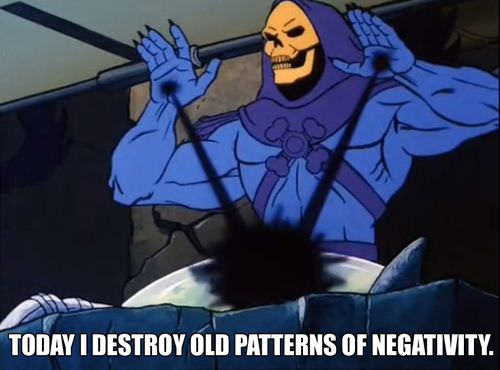

In [ ]:
dictionary = np.load('data2/oil.npz')
pos = dictionary.get('oil_yes')
neg = dictionary.get('oil_no')
spectrum = dictionary.get('spectrum')

spectrum = scipy.signal.resample(spectrum, 224) - spectrum.mean()
pos /= np.linalg.norm(pos, ord=2, axis=1).reshape(-1,1)
neg /= np.linalg.norm(neg, ord=2, axis=1).reshape(-1,1)

pos -= np.mean(pos, axis=1).reshape(-1,1)
neg -= np.mean(neg, axis=1).reshape(-1,1)

In [ ]:
W, mean = zca_whitening_matrix(neg)

In [ ]:
def whiten(m, W, mean):
    old_shape = m.shape
    m = m.reshape(-1, old_shape[-1])
    m = m - mean
    m = np.matmul(m, W)
    m = m.reshape(*old_shape)
    return m

In [ ]:
whitened_pos = whiten(pos, W, 0)
whitened_neg = whiten(neg, W, 0)
whitened_spectrum = whiten(spectrum, W, 0)

In [ ]:
def infer2(in_filename, out_filename):
    with rio.open(in_filename, 'r') as in_ds:
        profile = copy.deepcopy(in_ds.profile)
        profile.update(count=1, driver='GTiff', bigtiff='yes', compress='deflate', predictor='2', tiled='yes', dtype=np.float32, sparse_ok='yes')
        with rio.open(out_filename, 'w', **profile) as out_ds:
            for col in tqdm(range(0, in_ds.width, 512), position=0):
                width = min(col+512, in_ds.width) - col
                for row in tqdm(range(0, in_ds.height, 512), position=1, leave=False):
                    height = min(row+512, in_ds.height) - row
                    window = rasterio.windows.Window(col, row, width, height)
                    data = in_ds.read(1, window=window)
                    if np.abs(data).sum() == 0:
                        continue
                    data = np.transpose(in_ds.read(window=window).astype(np.float32), (1,2,0))
                    norm = np.linalg.norm(data, ord=2, axis=2)[..., None].astype(np.float32)
                    data /= norm
                    data -= np.mean(data, axis=2)[...,None]
                    data = whiten(data, W, 0)
                    data = np.dot(data, whitened_spectrum)
                    data[np.isnan(data)] = 0
                    data = data.reshape(1, width, height).astype(np.float32)
                    out_ds.write(data, window=window)

In [ ]:
np.dot(whitened_pos, whitened_spectrum).mean()

In [ ]:
np.dot(whitened_neg, whitened_spectrum).mean()

In [ ]:
in_filename = 'data2/f100517t01p00r14rdn_b/f100517t01p00r14rdn_b_sc01_ort_img.tif'
out_filename = 'data2/results/f100517t01p00r14rdn_b_sc01_ort_img_result_whitened.tif'
infer2(aviris, out_filename)

## Optimization ##

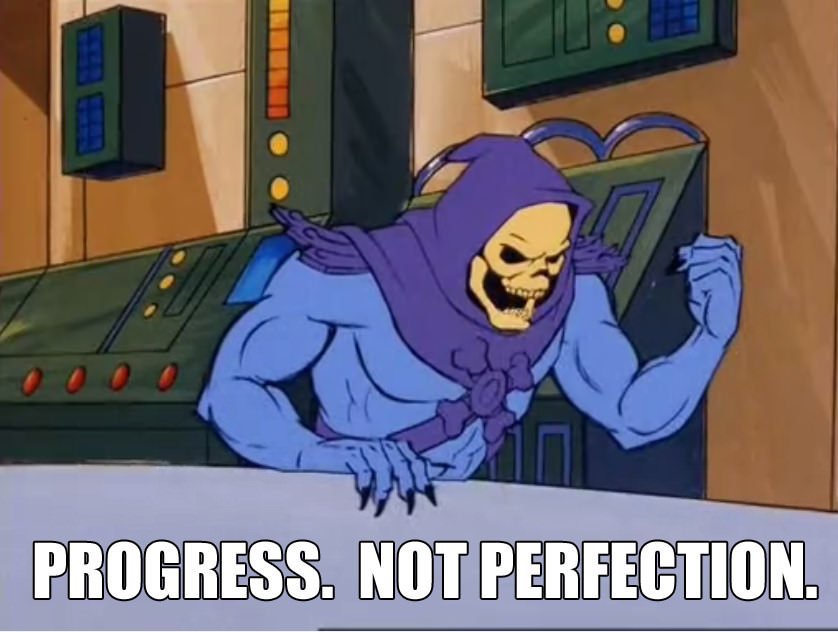

In [ ]:
device = torch.device("cuda")
# device = torch.device("cpu")

In [ ]:
indices = list(range(0, neg.shape[0], 64))

In [ ]:
neg_subset = neg[indices]

In [ ]:
ratio = int(neg_subset.shape[0] / pos.shape[0])
print(ratio)

In [ ]:
pos_repeated = np.repeat(pos, ratio, axis=0)

In [ ]:
samples = np.concatenate([neg_subset, pos_repeated], axis=0)
samples = torch.from_numpy(samples.astype(np.float)).unsqueeze(2).to(device)

labels = np.concatenate([np.zeros((neg_subset.shape[0], 1)), np.ones((pos_repeated.shape[0], 1))])
labels = torch.from_numpy(labels.astype(np.float)).unsqueeze(2).to(device)

target = torch.from_numpy(spectrum.astype(np.float)).unsqueeze(0).unsqueeze(2).to(device)

In [ ]:
model = MatchedFilter(W/5000, 0).to(device)

In [ ]:
model = vanilla_train(model, samples, labels, target, device, 1000)

In [ ]:
opt_W = model.W.cpu().detach().numpy()
opt_bias = model.bias.cpu().detach().numpy()

In [ ]:
W = opt_W.squeeze()

In [ ]:
whitened_spectrum = whiten(spectrum, W, 0)

In [ ]:
in_filename = 'data2/f100517t01p00r14rdn_b/f100517t01p00r14rdn_b_sc01_ort_img.tif'
out_filename = 'data2/results/f100517t01p00r14rdn_b_sc01_ort_img_result_whitened_opt.tif'
infer2(in_filename, out_filename)

## Band Selection ##

In [ ]:
start = neg_subset.shape[0]
length = pos.shape[0]
according_to_salience = argsort(model, samples, target, list(range(start, start+length)))

XXX: in this linear context, can work on average of positive pixels instead of all positive pixels

In [ ]:
according_to_salience

In [ ]:
np.savez('data2/W.npz', opt_W=opt_W, opt_bias=opt_bias, according_to_salience=according_to_salience)

# Test Selected Bands #

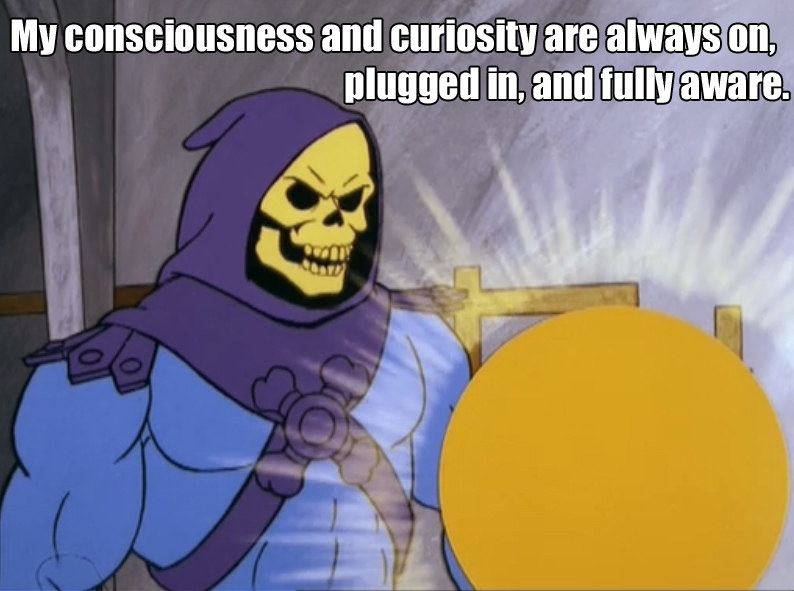

In [ ]:
dictionary = np.load('data2/W.npz')
according_to_salience = dictionary.get('according_to_salience')

In [ ]:
best_48 = according_to_salience[-48:].squeeze()
pos48 = pos[:, best_48].squeeze()
neg48 = neg[:, best_48].squeeze()
spectrum48 = spectrum[best_48].reshape(1,-1)

Should probably renormalize at this point.

In [ ]:
W, mean = zca_whitening_matrix(neg48)

In [ ]:
whitened_spectrum48 = whiten(spectrum48, W, 0).reshape(-1,1)

In [ ]:
def infer3(in_filename, out_filename):
    with rio.open(in_filename, 'r') as in_ds:
        profile = copy.deepcopy(in_ds.profile)
        profile.update(count=1, driver='GTiff', bigtiff='yes', compress='deflate', predictor='2', tiled='yes', dtype=np.float32, sparse_ok='yes')
        with rio.open(out_filename, 'w', **profile) as out_ds:
            for col in tqdm(range(0, in_ds.width, 512), position=0):
                width = min(col+512, in_ds.width) - col
                for row in tqdm(range(0, in_ds.height, 512), position=1, leave=False):
                    height = min(row+512, in_ds.height) - row
                    window = rasterio.windows.Window(col, row, width, height)
                    data = in_ds.read(1, window=window)
                    if np.abs(data).sum() == 0:
                        continue
                    data = np.transpose(in_ds.read(tuple(best_48), window=window).astype(np.float32), (1,2,0))
                    norm = np.linalg.norm(data, ord=2, axis=2)[..., None].astype(np.float32)
                    data /= norm
                    data -= np.mean(data, axis=2)[...,None]
                    data = whiten(data, W, 0)
                    data = np.dot(data, whitened_spectrum48)
                    data[np.isnan(data)] = 0
                    data = data.reshape(1, width, height).astype(np.float32)
                    out_ds.write(data, window=window)

In [ ]:
in_filename = 'data2/f100517t01p00r14rdn_b/f100517t01p00r14rdn_b_sc01_ort_img.tif'
out_filename = 'data2/results/f100517t01p00r14rdn_b_sc01_ort_img_result_whitened_48.tif'
infer3(in_filename, out_filename)

### Worst 48 ###

In [ ]:
best_48 = according_to_salience[48:].squeeze()
pos48 = pos[:, best_48].squeeze()
neg48 = neg[:, best_48].squeeze()
spectrum48 = spectrum[worst_48].reshape(1,-1)

In [ ]:
in_filename = 'data2/f100517t01p00r14rdn_b/f100517t01p00r14rdn_b_sc01_ort_img.tif'
out_filename = 'data2/results/f100517t01p00r14rdn_b_sc01_ort_img_result_whitened_worst_48.tif'
infer3(in_filename, out_filename)